<a href="https://colab.research.google.com/github/losirlu1411/llm-assignment/blob/main/llm_assignmnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and imports required libraries.

In [1]:
!pip install -q transformers
from transformers import BertForSequenceClassification
!pip install -U transformers datasets fsspec==2023.6.0
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 43.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.6.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

Load the dataset

In [2]:
from datasets import load_dataset

# Load the IMDB dataset
# It automatically downloads and caches the dataset.
# This should now work correctly after the environment cleanup and updates.
dataset = load_dataset("imdb")

print("Dataset loaded successfully!")
print(f"Training set size: {len(dataset['train'])} reviews")
print(f"Test set size: {len(dataset['test'])} reviews")
print("\nExample review from training set:")
print(dataset['train'][0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset loaded successfully!
Training set size: 25000 reviews
Test set size: 25000 reviews

Example review from training set:
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I 

Convert to pandas and perform a clean data inspection

In [3]:
import pandas as pd

# Convert Hugging Face dataset splits to Pandas DataFrames for easier EDA
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

print("--- Training Data Overview ---")
print(train_df.head())
print(train_df.info())
print(f"\nMissing values in training set:\n{train_df.isnull().sum()}")

print("\n--- Test Data Overview ---")
print(test_df.head())
print(test_df.info())
print(f"\nMissing values in test set:\n{test_df.isnull().sum()}")


--- Training Data Overview ---
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None

Missing values in training set:
text     0
label    0
dtype: int64

--- Test Data Overview ---
                                                text  label
0  I love sci-fi and am willing to put up with a ...      0
1  Worth the entertainment value of a rental, esp...      0
2  its a totally average

Visualising the class distribution

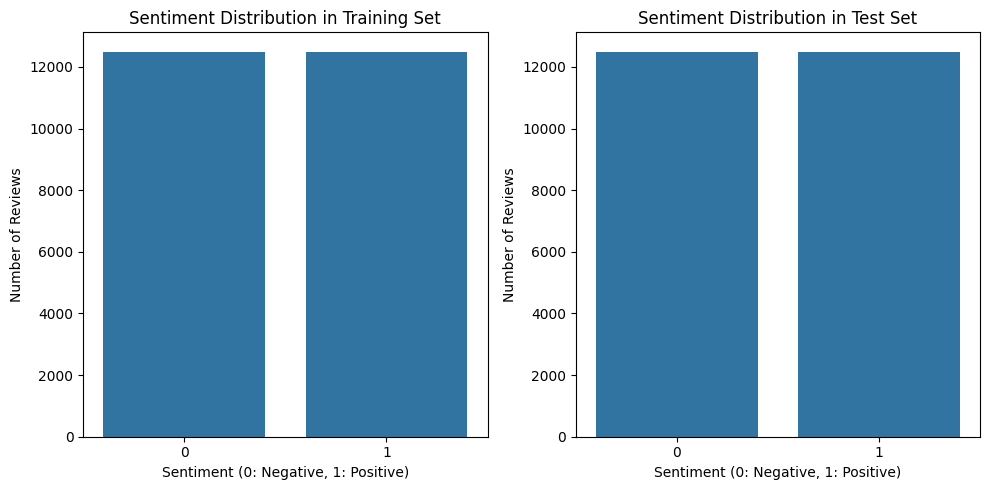


--- Label Counts ---
Training Set Label Counts:
 label
0    12500
1    12500
Name: count, dtype: int64

Test Set Label Counts:
 label
0    12500
1    12500
Name: count, dtype: int64


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='label', data=train_df)
plt.title('Sentiment Distribution in Training Set')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Number of Reviews')

plt.subplot(1, 2, 2)
sns.countplot(x='label', data=test_df)
plt.title('Sentiment Distribution in Test Set')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Number of Reviews')

plt.tight_layout()
plt.show()

print("\n--- Label Counts ---")
print("Training Set Label Counts:\n", train_df['label'].value_counts())
print("\nTest Set Label Counts:\n", test_df['label'].value_counts())

This analysis of review length is great for understanding potential truncation issues with BERT.

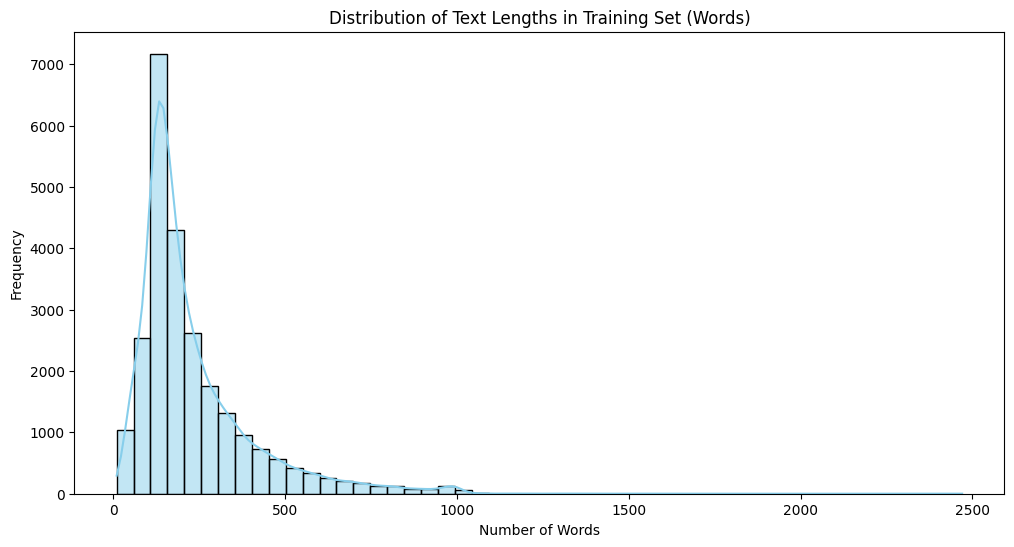


--- Text Length Statistics (Words) ---
Training Set Text Length:
 count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: text_length, dtype: float64

Test Set Text Length:
 count    25000.000000
mean       228.526680
std        168.883693
min          4.000000
25%        126.000000
50%        172.000000
75%        277.000000
max       2278.000000
Name: text_length, dtype: float64

Number of training reviews > 400 words: 3353


In [5]:
# Calculate text length (number of words)
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['text_length'] = test_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Text Lengths in Training Set (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

print("\n--- Text Length Statistics (Words) ---")
print("Training Set Text Length:\n", train_df['text_length'].describe())
print("\nTest Set Text Length:\n", test_df['text_length'].describe())

# Check for very long reviews that might be truncated by BERT's max_length (typically 512 tokens)
long_reviews_train = train_df[train_df['text_length'] > 400]
print(f"\nNumber of training reviews > 400 words: {len(long_reviews_train)}")


Word Count to visualise the reviews

NLTK stopwords downloaded.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



--- Top 20 Words in Positive Reviews (excluding stopwords) ---
br: 49235
film: 20940
movie: 19078
one: 13657
like: 9040
good: 7724
story: 6779
time: 6516
great: 6419
well: 6411
see: 6027
also: 5551
really: 5475
would: 5400
even: 4964
first: 4757
much: 4687
people: 4480
best: 4320
love: 4302

--- Top 20 Words in Negative Reviews (excluding stopwords) ---
br: 52636
movie: 24969
film: 19219
one: 13138
like: 11241
even: 7691
good: 7423
bad: 7401
would: 7036
really: 6263
time: 6211
see: 5452
story: 5209
much: 5077
get: 5040
people: 4807
make: 4722
could: 4685
made: 4541
first: 4307


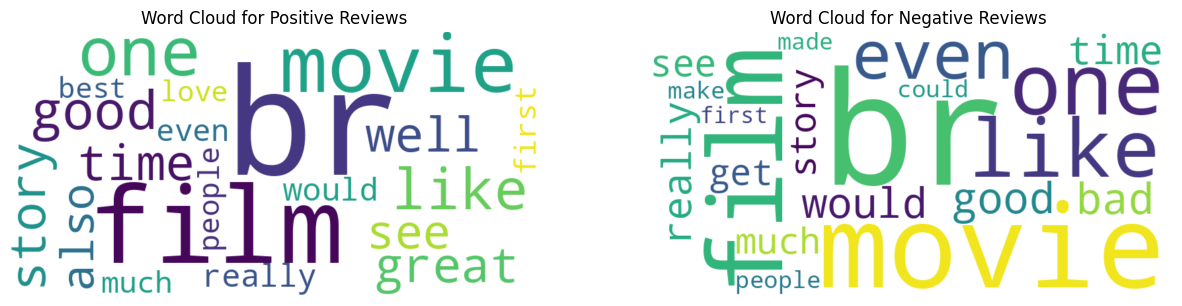

In [6]:
from collections import Counter
import re
import nltk # Import NLTK

# Download the 'stopwords' corpus if not already present
try:
    nltk.data.find('corpora/stopwords')
except LookupError: # Catch LookupError for missing resources
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
    print("NLTK stopwords downloaded.")
except Exception as e:
    print(f"An unexpected error occurred during NLTK stopwords download: {e}")

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Function to get most common words
def get_top_n_words(corpus, n=None, stopwords=None):
    words = []
    for text in corpus:
        # Simple tokenization: convert to lowercase and remove non-alphabetic characters
        words.extend(re.findall(r'\b[a-z]+\b', text.lower()))

    # Filter out stopwords
    if stopwords:
        words = [word for word in words if word not in stopwords]

    return Counter(words).most_common(n)


# Get positive and negative reviews
positive_reviews = train_df[train_df['label'] == 1]['text']
negative_reviews = train_df[train_df['label'] == 0]['text']

# Get top 20 words for each sentiment
top_positive_words = get_top_n_words(positive_reviews, n=20, stopwords=stop_words)
top_negative_words = get_top_n_words(negative_reviews, n=20, stopwords=stop_words)

print("\n--- Top 20 Words in Positive Reviews (excluding stopwords) ---")
for word, count in top_positive_words:
    print(f"{word}: {count}")

print("\n--- Top 20 Words in Negative Reviews (excluding stopwords) ---")
for word, count in top_negative_words:
    print(f"{word}: {count}")

# Optional: Plot word clouds if you have the wordcloud library installed
!pip install wordcloud
from wordcloud import WordCloud

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_positive_words))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')

plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_negative_words))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

Using of Berttokeniser and maping them

In [7]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer
# 'bert-base-uncased' is a common, smaller BERT model.
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

print(f"Tokenizer loaded: {tokenizer.name_or_path}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

# Example of tokenization
sample_text = "This movie was absolutely fantastic, I loved every moment!"
tokenized_output = tokenizer(sample_text, padding=True, truncation=True, return_tensors="pt")

print(f"\nOriginal text: '{sample_text}'")
print(f"Tokenized output (as PyTorch tensors):\n{tokenized_output}")
print(f"Input IDs: {tokenized_output['input_ids'][0].tolist()}")
print(f"Attention Mask: {tokenized_output['attention_mask'][0].tolist()}")
print(f"Tokens (decoded): {tokenizer.convert_ids_to_tokens(tokenized_output['input_ids'][0])}")

# Apply tokenization to the entire dataset
def tokenize_function(examples):
    # 'padding="max_length"' pads to the model's max length (512 by default for BERT).
    # 'truncation=True' truncates sequences longer than max_length.
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Use the .map() method to apply the tokenization function to all examples in the dataset.
# 'batched=True' processes multiple examples at once for efficiency.
tokenized_datasets = dataset.map(tokenize_function, batched=True)

print("\nDataset tokenization complete!")
print(f"Example tokenized training entry:\n{tokenized_datasets['train'][0]}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer loaded: bert-base-uncased
Vocabulary size: 30522

Original text: 'This movie was absolutely fantastic, I loved every moment!'
Tokenized output (as PyTorch tensors):
{'input_ids': tensor([[  101,  2023,  3185,  2001,  7078, 10392,  1010,  1045,  3866,  2296,
          2617,   999,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Input IDs: [101, 2023, 3185, 2001, 7078, 10392, 1010, 1045, 3866, 2296, 2617, 999, 102]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokens (decoded): ['[CLS]', 'this', 'movie', 'was', 'absolutely', 'fantastic', ',', 'i', 'loved', 'every', 'moment', '!', '[SEP]']


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]


Dataset tokenization complete!
Example tokenized training entry:
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered 

renaming the label to labels

In [8]:
# Remove the original 'text' column as it's no longer needed after tokenization.
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Rename the 'label' column to 'labels' to match the Trainer's expectation.
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set the format of the dataset to return PyTorch tensors.
tokenized_datasets.set_format("torch")

# Create a smaller subset for faster experimentation if needed (uncomment to use)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(5000))
print(f"\nUsing smaller datasets for quick test: Train {len(small_train_dataset)}, Eval {len(small_eval_dataset)}")



Using smaller datasets for quick test: Train 10000, Eval 5000


Changing Cpu to Gpu for training

In [9]:
from transformers import BertForSequenceClassification
import torch

# Load the pre-trained BERT model for sequence classification
# The 'num_labels' parameter tells the model how many output classes to expect.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU if available
model.to(device)

print(f"Model loaded: {model.config.name_or_path} with {model.num_parameters()} parameters.")
print(f"Model's classification head (classifier):\n{model.classifier}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: bert-base-uncased with 109483778 parameters.
Model's classification head (classifier):
Linear(in_features=768, out_features=2, bias=True)


Defining trainnig Arguments

In [10]:
import numpy as np
import evaluate # Hugging Face's evaluate library

# Load the accuracy metric from the evaluate library
metric = evaluate.load("accuracy")

# Define a function to compute metrics during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to predicted class IDs by taking the argmax
    predictions = np.argmax(logits, axis=-1)
    # Compute accuracy using the loaded metric
    return metric.compute(predictions=predictions, references=labels)

from transformers import TrainingArguments

# Define training arguments (hyperparameters)
training_args = TrainingArguments(
    output_dir="./results",          # Directory where model checkpoints and logs will be saved
    eval_strategy="epoch",     # Evaluate the model at the end of each epoch
    save_strategy="epoch",     # Save the model checkpoint at the end of each epoch
    learning_rate=2e-5,              # Common learning rate for BERT fine-tuning
    per_device_train_batch_size=8,  # Batch size per GPU/CPU during training
    per_device_eval_batch_size=8,   # Batch size per GPU/CPU during evaluation
    num_train_epochs=3,              # Total number of training epochs (typically 2-4 for fine-tuning)
    weight_decay=0.01,               # L2 regularization to prevent overfitting
    logging_dir="./logs",            # Directory for TensorBoard logs
    logging_steps=1000,               # Log training metrics every 500 steps
    save_total_limit=2,              # Only save the last 2 model checkpoints
    load_best_model_at_end=True,     # Load the best model (based on metric_for_best_model) at the end of training
    metric_for_best_model="accuracy",# Metric to monitor for determining the "best" model
    report_to="none",                # Disable reporting to external services like Weights & Biases
)

print("Metrics function and TrainingArguments defined.")

Metrics function and TrainingArguments defined.


Train the model

In [11]:
from transformers import Trainer

# Initialize the Trainer
trainer = Trainer(
    model=model,                       # The model to be trained
    args=training_args,                # The training arguments defined above
    train_dataset=tokenized_datasets["train"], # The training dataset
    eval_dataset=tokenized_datasets["test"],   # The evaluation dataset (used for monitoring performance)
    tokenizer=tokenizer,               # The tokenizer, used for padding/truncation during batching
    compute_metrics=compute_metrics,   # The function to compute evaluation metrics
)

print("Trainer initialized. Starting fine-tuning...")

# Start the training process
trainer.train()

print("\nFine-tuning complete!")

/tmp/ipython-input-11-1267127071.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer initialized. Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.255500,0.242765,0.924000
2,0.143900,0.269262,0.938160


Epoch,Training Loss,Validation Loss,Accuracy
1,0.255500,0.242765,0.924000
2,0.143900,0.269262,0.938160
3,0.069900,0.306928,0.941560



Fine-tuning complete!


Visualising the confusion Matrix

Evaluating the fine-tuned model on the test set...


Evaluation Results: {'eval_loss': 0.30692774057388306, 'eval_accuracy': 0.94156, 'eval_runtime': 170.1978, 'eval_samples_per_second': 146.888, 'eval_steps_per_second': 18.361, 'epoch': 3.0}

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94     12500
    Positive       0.94      0.94      0.94     12500

    accuracy                           0.94     25000
   macro avg       0.94      0.94      0.94     25000
weighted avg       0.94      0.94      0.94     25000



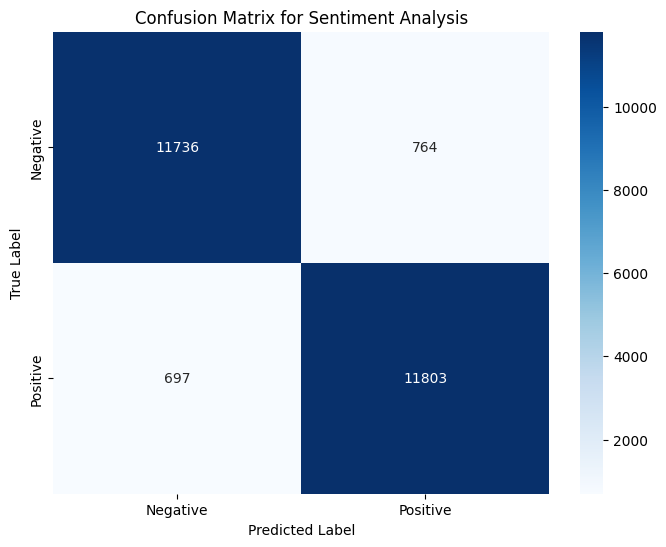

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Evaluating the fine-tuned model on the test set...")
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Get predictions on the test set
predictions_output = trainer.predict(tokenized_datasets["test"])
logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted labels
predicted_labels = np.argmax(logits, axis=-1)

# Generate classification report
print("\n--- Classification Report ---")
# Labels are 0 for negative, 1 for positive
target_names = ['Negative', 'Positive']
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Generate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()

Printing the predictions

In [13]:
# Function to predict sentiment for a given text
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")

    # Move inputs to the same device as the model (GPU/CPU)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Set model to evaluation mode
    model.eval()

    # Perform inference without calculating gradients
    with torch.no_grad():
        outputs = model(**inputs)

    # Get logits and apply softmax to get probabilities
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)

    # Get the predicted class and its score
    predicted_class_id = torch.argmax(probabilities, dim=-1).item()
    predicted_score = probabilities[0][predicted_class_id].item()

    # Map class ID to sentiment label
    sentiment_label = "Positive" if predicted_class_id == 1 else "Negative"

    return sentiment_label, predicted_score

# Test with some example sentences
examples = [
    "This movie was an absolute masterpiece! I highly recommend it.",
    "I found the plot to be incredibly dull and the acting was subpar.",
    "It was an okay film, nothing groundbreaking but not terrible.",
    "The special effects were amazing, but the story made no sense.",
    "Completely blown away by the performances and direction."
]

print("\n--- Sentiment Predictions on New Text ---")
for i, text in enumerate(examples):
    label, score = predict_sentiment(text)
    print(f"Text {i+1}: '{text}'")
    print(f"  Predicted Sentiment: {label} (Confidence: {score:.4f})\n")


--- Sentiment Predictions on New Text ---
Text 1: 'This movie was an absolute masterpiece! I highly recommend it.'
  Predicted Sentiment: Positive (Confidence: 0.9997)

Text 2: 'I found the plot to be incredibly dull and the acting was subpar.'
  Predicted Sentiment: Negative (Confidence: 0.9997)

Text 3: 'It was an okay film, nothing groundbreaking but not terrible.'
  Predicted Sentiment: Negative (Confidence: 0.9958)

Text 4: 'The special effects were amazing, but the story made no sense.'
  Predicted Sentiment: Negative (Confidence: 0.9994)

Text 5: 'Completely blown away by the performances and direction.'
  Predicted Sentiment: Positive (Confidence: 0.9993)

